# Web Crawler

Collect text data from the PTT forum, process the article texts, and finally create a word cloud for a quick overview of the topics in these collected texts.

## Crawling Data from PTT

In [1]:
import requests
from bs4 import BeautifulSoup as soup  # HTML data structure
from lxml import etree


# extract article hyperlinks from an index page
def extractArtLinks(url):
    r = requests.get(url, cookies={'over18': '1'})
    page_soup = soup(r.text, "html.parser")
    containers = page_soup.findAll("div", {"class": "r-ent"})
    art_links = []
    for container in containers:
        # Finds all link tags "a" from within the first div.
        art_link = container.find('a')
        if art_link:
            #print(art_link['href'])
            #print(container.find('div',{'class':'title'}).get_text())
            art_meta = container.find('div', {'class': 'meta'})
            #print(art_meta.find('div',{'class':'author'}).get_text())
            #print(art_meta.find('div',{'class':'date'}).get_text())

            art_links.append({
                'push':
                container.find('div', {
                    'class': 'nrec'
                }).get_text(),
                'title':
                container.find('div', {
                    'class': 'title'
                }).get_text().strip(),
                'date':
                art_meta.find('div', {
                    'class': 'date'
                }).get_text(),
                'author':
                art_meta.find('div', {
                    'class': 'author'
                }).get_text(),
                'link':
                art_link['href'],
                'text':
                extractArtText('https://www.ptt.cc' + art_link['href'])
            })

    return (art_links)


# find the previous index page link
def findPrevIndex(url):
    r = requests.get(url, cookies={'over18': '1'})
    page_soup = soup(r.text, "html.parser")
    btn = page_soup.select('div.btn-group > a')
    up_page_href = btn[3]['href']
    next_page_url = 'https://www.ptt.cc' + up_page_href
    return (next_page_url)


# extract article contents from  the article hyperlink
def extractArtText(url):
    r = requests.get(url, cookies={'over18': '1'})
    #page_soup = soup(r.text, "lxml")
    #print(page_soup.find("div",{"id":"main-content"}).get_text())
    #art_text=page_soup.select('div#main-content', limit=1)[0].text
    content = r.content.decode()
    html = etree.HTML(content)
    art_text = html.xpath(
        "//div[@id='main-content']/text()[not(self::div|self::span[@class='f2'])]"
    )
    return ''.join(list(art_text))

In [2]:
## Debug Use

# url = 'https://www.ptt.cc/bbs/Food/M.1602332821.A.6F3.html'
# r = requests.get(url, cookies={'over18': '1'})
# #page_soup = soup(r.text, "lxml")
# #print(page_soup.find("div",{"id":"main-content"}).get_text())
# #art_text=page_soup.select('div#main-content', limit=1)[0].text
# content = r.content.decode()
# html = etree.HTML(content)
# art_text = html.xpath(
#     "//div[@id='main-content']/text()[not(self::div|self::span[@class='f2'])]")

# print(''.join(list(art_text)))

```{note}
For CSS selector, don't know how to set conditional criteria to select only texts under div#main-container but not those included in the child div.article-metaline and span.f2.

So here I use the XPath, which requires the lxml package.
```

In [3]:
# main()
num_of_index_page = 5
board_name = 'Food'
url = 'https://www.ptt.cc/bbs/{}/index.html'.format(board_name)
all_links = []
for page in range(1, num_of_index_page):
    all_links = all_links + extractArtLinks(url)
    url = findPrevIndex(url)
len(all_links)

69

In [4]:
type(all_links[2])
print(all_links[2])

{'push': '', 'title': '[食記] 台中 湯棧中清店(麻油鍋、燒酒鍋好吃)', 'date': '10/29', 'author': 'minglong1985', 'link': '/bbs/Food/M.1603911988.A.545.html', 'text': '\n   餐廳名稱：湯棧中清店\n   消費時間：2020年/10月\n   地址：台中市北屯區中清路二段1037號\n   電話：04 2425 0822\n   營業時間：11:00–02:00\n\n網誌圖文版:\n\n身為台中人沒吃過湯棧真的會被笑，他都開這麼久了我第一次吃\n\n之前每次突然想吃都訂不到位子，這次託朋友的福終於吃到了\n\n湯棧中清店位在北屯區中清路二段上，超大一間，外觀真的很壯觀\n\n還好有訂位門口超多人在排隊，歐對了順便講一下停車場\n\n湯棧中清店是沒有停車場的歐，隔壁那個停車場是健身中心的不要停錯\n\n然後在旁邊還有一個收費停車場超級貴，假日半小時35，一小時70阿\n\n我們停到湯棧後方的馬路周邊超多停車格的，繞一下非常好找，可以不用停到停車場\n\n整體工業風格，設計很有質感，輕井澤體系的火鍋店都很不錯，且環境都很霸氣\n\n\n座位真的很多，四人、六人、八人大桌都有，且都有隔開\n\n感覺很溫馨又舒適，很有開放式小包廂的感覺，下次家庭聚餐就選這\n\n\n湯棧的三大招牌鍋就是\n\n麻油雞鍋(含酒)\n\n燒酒雞鍋(含酒)\n\n剝皮辣椒雞鍋(含有微量紹興酒)\n\n然後還有中清店才有的合興沙茶火鍋，我們四個人點四個不同的鍋\n\n左上角麻油雞鍋、左下角沙茶鍋、右上角蔬菜鍋、右下角燒酒雞鍋\n\n這次朋友懷孕不想吃太重口味，所以點了蔬菜火鍋，看起來超健康的\n\n且湯頭看起來也很不錯，吃素的朋友也不擔心沒鍋吃\n\n剝皮辣椒鍋好像也很厲害，下次來吃看看\n\n\n特選牛腹肉麻油火鍋$308\n\n火鍋均附白飯、蔬菜盤、主餐、冬瓜茶、冰沙\n\n點麻油鍋或是燒酒鍋會有雙主餐，因為燒酒鍋跟麻油鍋裏面還有雞肉\n\n所以如果你點主餐是牛肉，就可以同時吃到牛肉跟雞肉超棒的阿\n\n朋友的老公超喜歡這間，大推給我們，真的很不錯呢\n\n這就是麻油雞鍋裡面的雞肉，滿多塊的耶\n\n難怪大家都會點麻油雞鍋跟燒酒雞鍋，CP值超高的阿\n\n歐重點還有

In [5]:
print('Push: {push:s} \n'
      'title: {title:s} \n'
      'date: {date:s} \n'
      'author: {author:s} \n'
      'link: {link:s} \n'
      'text: {text:.20} \n'.format(**all_links[3]))

Push: 1 
title: [食記] 台北 Bogart’s Smokehouse 美式木柴烤 
date: 10/29 
author: leafphoto 
link: /bbs/Food/M.1603923352.A.4CF.html 
text: 
  餐廳名稱：Bogart’s Smo 



## Text Normalization

In [6]:
import sys
sys.path.insert(1, '../nlp')
import text_normalizer_zh as tn

In [7]:
print(all_links[3]['text'])


  餐廳名稱：Bogart’s Smokehouse 美式木柴烤肉屋
  電話：02 2785 2217
  營業時間：11:30–20:00(週日11:30–16:00，週一公休)
  地址：台北市南港區南港路一段255號
  無音樂。有圖真相網誌版：
  消費時間：2020.09
  每人平均價位：300
  可否刷卡：不可
  有無包廂：無
  推薦菜色：手撕豬肉
  官網：略

 =====我是分隔線======
想找南港聚餐好地方？『Bogart’s Smokehouse 美式木柴烤肉屋』肯定是熱門選項！
每次走南港路一段都會經過『Bogart’s Smokehouse』，好奇下上網查了才知道原來是賣
美式烤肉BBQ，
在台灣美式餐廳固然不少，但主打smokehouse其實並不多，『Bogart’s Smokehouse』的
主廚是美國人，店裡主賣牛胸肉漢堡、豬肋排、手撕豬等，
重點是我專程跑了三次才吃到！雖然營業時間到晚上八點，但實際上某次我五點半過來，
店內已全數完售….
不死心之下又跑了第三次，才如願吃到，我真沒想到竟然這麼搶手！

『Bogart’s Smokehouse 美式木柴烤肉屋』是先點餐、結帳再入座，點餐時不用太擔心
語言問題，美國大叔會說中文，直接點餐就可以了！
店內裝潢風格簡單俐落的美式風格，座位設計從2人桌到6人桌都有，蠻適合聚餐！

『Bogart’s Smokehouse 美式木柴烤肉屋』菜單價目表 (2020.09)
主餐部份，很多人推薦這邊的豬肋排、手撕豬、牛胸肉、手撕雞，這邊的餐點通常都會提
早完售，晚上來的話選擇不多。
配菜部份有烤焗豆、起司通心麵、高麗菜沙拉、馬鈴薯沙拉、自製醃酸黃瓜，
值得一提的是，如果漢堡麵包套餐選擇『特大份量』，配菜可以選擇兩種，因此飽足感也
會爆棚！

這天超餓，幸好老闆上餐也爆快！可惜今天騎車，不然就多點兩杯啤酒了！

『Bogart’s Smokehouse』- 手撕豬肉 (正常份量)
這份是朋友點的正常份量。

『Bogart’s Smokehouse』- 烤焗豆
其實剛看我還以為納豆 哈哈
說實在賣相不是我喜歡的，但口味意外還不賴！

『Bogart’s Smokehouse』- 手撕豬肉 (特大份量)
特大份量不僅肉量增加，連配餐也多一份！

『Bogart’s Smokehouse

In [8]:
raw = [art['text'] for art in all_links if len(art) != 0 and len is not None]
raw_normalized = tn.normalize_corpus(raw)

Building prefix dict from /Users/Alvin/GoogleDrive/_MySyncDrive/RepositoryData/data/jiaba/dict.txt.jiebatw.txt ...


Loading model from cache /var/folders/n7/ltpzwx813c599nfxfb94s_640000gn/T/jieba.u1b52b47246a0f2e6497af6bbe107adac.cache


Loading model cost 0.556 seconds.


Prefix dict has been built successfully.


In [9]:
import pandas as pd

corpus_df = pd.DataFrame({"raw": raw, "normalized": raw_normalized})

In [10]:
corpus_df.head(2)

,raw,normalized
0,\n\n 餐廳名稱：台北喜來登-十二廚\n 地址：台北市中正區忠孝東路一段12號1樓\n...,餐廳 名稱 台北 喜來登 十 二廚 地址 台北市 中正區 忠孝東路 一段 號 樓 電話 消費...
1,\n消費時間：109/10\n地址：台北市中山區南京東路三段109巷3號\n電話：02 25...,消費 時間 地址 台北市 中山區 南京東路 三段 巷 號 電話 營業 時間 每人 平均 價位...


In [11]:
raw[5]

'\n                    \n                                                          2017.6.4修訂\n\n\n1.置入水桶禁言期滿，將由系統自動解除限制，若到期而未解禁請寫信詢問板主。\n\n2.文章被刪除者，若欲了解刪文原因或尋回備份，請洽精華區的資源回收桶。\n\n\n\n\n\n\n\n\n             \n\n\n\n\n\n\n    ：Chat82gether板、e-Shopping板\n    ：Instant_Food 即時食物板\n    ：fastfood 速食板\n    ：CVS 便利商店板、hypermall 大賣場板\n    ：Snacks板、Sweet板\n    ：Drinks板\n\n    張貼第1條各項所列之文章，除原文刪除，視情況可併處。\n\n\n註：若對板規1之(1)涵攝範圍不夠清楚，請參閱精華區 和 \n    有兩篇更詳細的補充說明。\n\n\n\n\n\n  ，\n    但需配合下列事項：\n    \n\n    未配合上述規定之店家廣宣，初犯，劣退＋水桶禁言60天；\n    累犯，劣退＋終身水桶。推文違規廣宣者，終身水桶。\n\n\n\n  Food板目前有限度的開放廣宣只接受兩種形式：\n\n  \n\n  網路行銷、廣告公司或第三方(如銀行、網站)與餐廳合辦的間接合作活動不予開放。\n\n\n\n\n  接受餐廳招待試吃者，張貼食記必須誠實揭露，並以為標題，勿自創標題。\n    與『』有關的廣宣，不分張貼者為，\n    須一併計入廣宣額度限制－\n    比照廣宣規定辦理，但團購服務缺失抱怨文則不受限制。\n\n    欲張貼試吃廣宣者，請自行查詢板上是否已有未期滿的同店廣宣，\n    若已有則不得張貼。違反上述規定者，刪除試吃食記，。\n    累犯者，；，\n    原受處分ID與分身ID處分。\n\n註：1.精華區 對本板可接受的試吃種類有進一步說明，歡迎參閱。\n\n    2.『』張貼限制期間，係指可開放新一篇廣宣。\n      例：某餐廳於在板上有廣宣下次可貼廣宣時間：。\n                  在板上有廣宣下次可貼廣宣時間：。\n      特例：      在板上有廣

In [12]:
raw_normalized[4]

'餐廳 名稱 林家 素食 消費 時間 年 月 地址 台南市 北區 長榮 四段 號 電話 營業 時間 週一 週日 每人 平均 價位 元 左右 可否 刷卡 忘記 問 有無 包廂 無 推薦 菜色 麻辣 豆腐 鍋 麻油 麵線 網路 很 推 隱藏版 蘿蔔 絲 煎餃 網誌 版 台南 長榮路 上 的 林家 素食 是 台南 有名 素食 餐廳 我放 在 口袋 名單 很 久 一直 找不到 機會 去 吃 上 週六 總算 有 機會 母女倆 去 用餐 林家 素食 的 招牌 料理 有 砂鍋 麻油 細 麵 花生 湯黃 猴頭菇 燴飯 港式 素 蘿蔔糕 還有 隱藏版 菜單 熟客 才 知道 的 蘿蔔 絲 煎餃 都 蠻 推薦 大家 點點 看 的 林家 素食 整體 來 說 價格 比較 高 不過 餐點 的確 表現 不錯 用餐 環境 也 乾淨 舒服 之後 還 會 和 我媽 再訪 林家 素食 在 文 南路 有 分店 我們 來 的 是 長榮路 總店 離 成功 大學 很近 目前 小 黑板 推薦 鐵板 猴菇 雙燒 實品 長 這樣子 林家 素食 用餐 環境 座位 不多 裝潢 簡單 週六 晚餐 用餐 一下子 就 客滿 生意 蠻好 的 上菜 速度 非常 快 我媽 好奇 地問 我 廚房 是 很多 人 嗎 我媽 說 怎麼 沒 看到 筷子 原來 有 特別 消毒 的 機器 挺 有意思 忘記 拍 筷子 的 機器 了 小菜 區 我 本來 想要 拿 破布子 豆皮 但 我媽 以為 是 破布子 蛋 她 不 讓 我 拿 破布子 豆皮 是 限定 產品 推薦 大家 可以 嚐鮮 林家 素食 菜單 分為 現炒 類 麵類 精緻 合菜 湯類 小點 鐵板 砂鍋 火鍋 類 店員 推薦 顆 元 蘿蔔 絲 煎餃 我們 因為 點 道 就 這道 事 後 想想 有點 可惜 因為 網路 上 對 這道 隱藏版 菜單 相當 稱讚 花生 湯 網路 上 很 推薦 的 鹹湯 好像 沒有 吃過 花生 鹹湯 嚐鮮 看看 裡頭 有 素肉 和 花生 湯頭 好喝 砂鍋 麻油 麵線 吃 這道 得 要 趁熱 快點 吃 不然 麵線 很 容易 糊掉 香氣 四溢 的 麻油 香 邊吃 麵線 邊配 猴頭菇 枸杞 蔬菜 很 好吃 耶 麻辣 臭豆腐 鍋 我媽 看到 辣度 標示 有 根 辣椒 很 奧客 問 店員 能 做 顆 辣椒 的 辣度 嗎 店員 說 辣度 都 是 固定 不能 調整 後來 喝 這 湯頭 其實

- [Unicode List](https://en.wikipedia.org/wiki/List_of_Unicode_characters)
- [Unicode Categories](https://unicodebook.readthedocs.io/unicode.html)

In [13]:
text = raw[0]
text

'\n\n  餐廳名稱：台北喜來登-十二廚\n  地址：台北市中正區忠孝東路一段12號1樓\n  電話：02 2321 1818\n  消費時間：2020/10/27\n\n\n  事發經過：\n\n在我結完帳後，用餐到大約20:20-20:30，\n\n我坐沙發面對走道，如照片中的地方，\n突然兩桌沙發中間突然擠進了一位女士，\n然後，沒有帶口罩，邊聊天邊咳嗽，\n我跟朋友還在用餐，\n陌生沒有用餐的女士一直待了快15-20分鐘，\n服務人員來回穿梭，都視而不見這位女士，\n當然也沒有服務人員請她離開。\n\n重點是～\n大家都已經結完帳，已經有人離席，有空桌。\n服務人員帶這位女士進來時，\n連問都不問，就塞人非用餐的客人入席，\n若她有流感呢？\n或是她是居家檢疫偷跑出來的人呢？\n疫情期間，五星級飯店餐廳無法控管客人？\n還讓非用餐的人進入自助餐廳！\n\n\n#讓我理智線完全斷掉是左邊桌\n#照片已經修飾，請不要在用餐時觀看照片\n\n\n我的左邊座位鄰居，坐了一位穿拖鞋的女士，\n我才在反感右邊咳嗽的人，\n這位女士可能因為用餐完了，\n直接當場拖掉鞋子翹腳，\n她座位後面就是甜點區，\n而且完全沒有服務人員制止。\n\n我去住與吃過的台北市五星級飯店自助餐廳，\n入場時針對服裝儀容不符合的客人，\n都會告知～\n餐廳不可以穿拖鞋！（告誡客人）\n客人一定會說～下次會注意！\n然後把服裝儀容不整的客人，\n安排在邊邊角角的桌子，讓其他客人可以放心的用餐！\n\n所以我也只能認為～\n喜來登十二廚餐廳的服務人員，\n完全不把客人穿拖鞋入內用餐當一回事，\n才把這位客人安排在走道用餐，\n因為沒有制止客人，\n所以她當然直接在大眾用餐環境拖鞋與翹腳！\n我真的非常懷疑～真的有在控管與防疫嗎？\n\n\n#理智線斷裂後直接找餐廳經理投訴#\n\n遞交客戶意見調查表時，\n當場客訴右邊來路不明沒有消費的人，\n與左邊穿拖鞋翹角的鄰居，\n請餐廳經理處理，\n餐廳經理只有處理右邊桌的人，\n左邊桌的人沒處理，\n然後也沒有主動問我們是否需要換座位？\n然後，客訴的當下餐廳經理也沒道歉！\n\n所以我只能認定～\n這就是喜來登十二廚的服務與衛生與防疫的態度。\n\n我到現在一直在懷疑，\n我去的用餐的地方是喜來登？還是路邊攤？\n\n我之前去喜來登餐廳那麼多次，\n

In [14]:
import unicodedata

result = ''.join(ch for ch in text
                 if unicodedata.category(ch)[0] not in ['P', 'S'])
result

'\n\n  餐廳名稱台北喜來登十二廚\n  地址台北市中正區忠孝東路一段12號1樓\n  電話02 2321 1818\n  消費時間20201027\n\n\n  事發經過\n\n在我結完帳後用餐到大約20202030\n\n我坐沙發面對走道如照片中的地方\n突然兩桌沙發中間突然擠進了一位女士\n然後沒有帶口罩邊聊天邊咳嗽\n我跟朋友還在用餐\n陌生沒有用餐的女士一直待了快1520分鐘\n服務人員來回穿梭都視而不見這位女士\n當然也沒有服務人員請她離開\n\n重點是\n大家都已經結完帳已經有人離席有空桌\n服務人員帶這位女士進來時\n連問都不問就塞人非用餐的客人入席\n若她有流感呢\n或是她是居家檢疫偷跑出來的人呢\n疫情期間五星級飯店餐廳無法控管客人\n還讓非用餐的人進入自助餐廳\n\n\n讓我理智線完全斷掉是左邊桌\n照片已經修飾請不要在用餐時觀看照片\n\n\n我的左邊座位鄰居坐了一位穿拖鞋的女士\n我才在反感右邊咳嗽的人\n這位女士可能因為用餐完了\n直接當場拖掉鞋子翹腳\n她座位後面就是甜點區\n而且完全沒有服務人員制止\n\n我去住與吃過的台北市五星級飯店自助餐廳\n入場時針對服裝儀容不符合的客人\n都會告知\n餐廳不可以穿拖鞋告誡客人\n客人一定會說下次會注意\n然後把服裝儀容不整的客人\n安排在邊邊角角的桌子讓其他客人可以放心的用餐\n\n所以我也只能認為\n喜來登十二廚餐廳的服務人員\n完全不把客人穿拖鞋入內用餐當一回事\n才把這位客人安排在走道用餐\n因為沒有制止客人\n所以她當然直接在大眾用餐環境拖鞋與翹腳\n我真的非常懷疑真的有在控管與防疫嗎\n\n\n理智線斷裂後直接找餐廳經理投訴\n\n遞交客戶意見調查表時\n當場客訴右邊來路不明沒有消費的人\n與左邊穿拖鞋翹角的鄰居\n請餐廳經理處理\n餐廳經理只有處理右邊桌的人\n左邊桌的人沒處理\n然後也沒有主動問我們是否需要換座位\n然後客訴的當下餐廳經理也沒道歉\n\n所以我只能認定\n這就是喜來登十二廚的服務與衛生與防疫的態度\n\n我到現在一直在懷疑\n我去的用餐的地方是喜來登還是路邊攤\n\n我之前去喜來登餐廳那麼多次\n覺得喜來登餐廳不錯\n所以才訂12月與1月的住宿\n結果1027第一次去改裝後的十二廚\n就遇到這種狀況我也現在都開始懷疑\n住宿防疫工作與衛生是否有做好控管\n\n

## Word Cloud

In [15]:
from collections import Counter
import imageio
from nltk.tokenize import WhitespaceTokenizer
from wordcloud import WordCloud, ImageColorGenerator
from matplotlib import pyplot as plt

In [16]:
## Check font paths
## !fc-list :lang=zh

ws = WhitespaceTokenizer()

tokens = [ws.tokenize(text) for text in raw_normalized]

In [17]:
from collections import Counter

# corpus token freq
tokens_freq = Counter(sum(tokens, []))
sorted(tokens_freq.items(), key=lambda x: x[1], reverse=True)

# corpus token freq per document
tokens_freq_per_doc = [Counter(wt) for wt in tokens]

# corpus token docfreq
tokens_df = Counter()

# map(tokens_df.update, (tfpd.keys() for tfpd in tokens_freq_per_doc))

for tfpd in tokens_freq_per_doc:
    tokens_df.update(tfpd.keys())

print(tokens_df)

Counter({'的': 68, '時間': 67, '是': 65, '有': 64, '地址': 62, '號': 60, '電話': 60, '消費': 60, '了': 59, '營業': 58, '在': 56, '也': 56, '人': 56, '就': 56, '餐廳': 55, '吃': 54, '名稱': 52, '都': 52, '很': 52, '不': 51, '可以': 51, '來': 51, '月': 50, '上': 50, '我': 49, '但': 48, '會': 47, '年': 46, '沒有': 43, '說': 43, '菜單': 42, '比較': 41, '到': 40, '價位': 40, '覺得': 39, '好': 39, '圖文': 39, '因為': 38, '多': 38, '版': 38, '讓': 37, '就是': 37, '要': 37, '每人': 37, '跟': 36, '推薦': 36, '不錯': 35, '喜歡': 34, '口感': 34, '店家': 34, '沒': 33, '平均': 33, '口味': 33, '好吃': 33, '元': 33, '用餐': 32, '想': 32, '和': 32, '網誌': 32, '看': 32, '後': 31, '所以': 31, '真的': 31, '看到': 31, '非常': 30, '選擇': 30, '以': 30, '整體': 30, '無': 30, '應該': 30, '其': 29, '他': 29, '我們': 29, '更': 29, '又': 29, '小': 29, '餐點': 29, '不過': 29, '味道': 29, '時': 28, '才': 28, '還': 28, '大': 28, '從': 27, '能': 26, '還是': 26, '還有': 26, '價格': 26, '有點': 26, '去': 25, '再': 25, '得': 25, '很多': 25, '與': 24, '這': 24, '包廂': 24, '話': 24, '刷卡': 24, '菜色': 24, '其實': 24, '可': 24, '特別': 24, '不會': 24, '中': 23, '除了': 

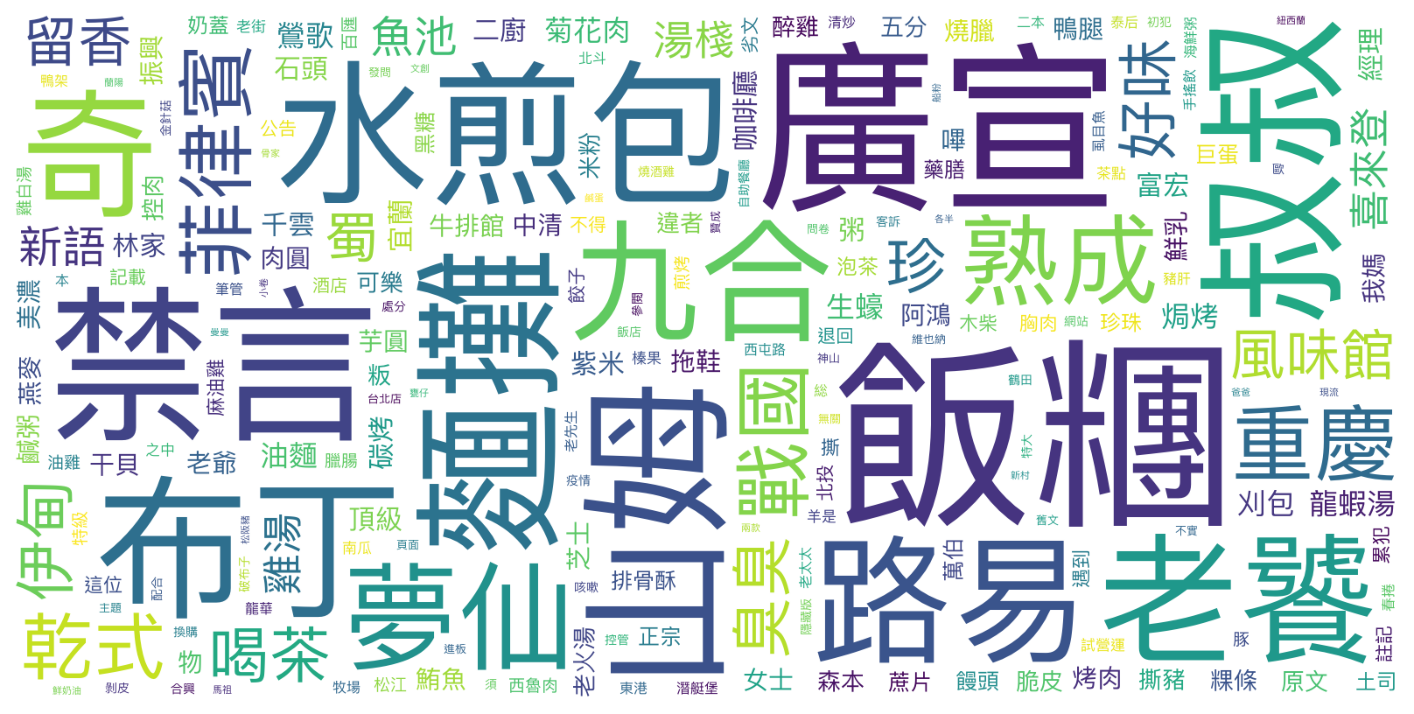

In [18]:
## Load stopwords
with open(
        '../../../RepositoryData/data/stopwords/tomlinNTUB-chinese-stopwords.txt'
) as f:
    stopwords = [w.strip() for w in f.readlines()]

# Create stopwords ad hoc
stopwords = set([
    '文章', '食記', '水桶', '刪除', '投票', '刪文', '連結', '板面', '板主', '規定', '違規', '使用',
    '所以', '禁止', '天', '票'
])

# Cutoff based on docfreq and stopwords
words2plot = dict([(w, tokens_freq[w]) for w, df in tokens_df.items()
                   if df < 2 and w not in stopwords and tokens_freq[w] >= 2])

wordcloud = WordCloud(font_path="/System/Library/Fonts/PingFang.ttc",
                      background_color='white',
                      stopwords=stopwords,
                      width=1600,
                      height=800,
                      margin=20)
# wordcloud.generate(' '.join([w for w in tokens_unnest if w not in stopwords]))
wordcloud.generate_from_frequencies(words2plot)
plt.figure(figsize=(20, 10), facecolor='w')
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=1)
plt.show()
#plt.savefig('../data/twp-wordcloud2.png', facecolor='k', bbox_inches='tight')

:::{admonition} Exercise
How to seperate post texts from push texts?
:::
